# Using Keras Pre-trained Deep Learning models for your own dataset

## Feature Extraction using ConvNets

In [1]:
# filter warnings
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# keras imports
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.preprocessing import image
from keras.models import Model
from keras.models import model_from_json
from keras.layers import Input

# other imports
from sklearn.preprocessing import LabelEncoder
import numpy as np
import glob
import cv2
import h5py
import os
import json
import datetime
import time

# load the user configs
with open('conf/conf.json') as f:    
  config = json.load(f)

# config variables
model_name    = config["model"]
weights     = config["weights"]
include_top   = config["include_top"]
train_path    = config["train_path"]
features_path   = config["features_path"]
labels_path   = config["labels_path"]
test_size     = config["test_size"]
results     = config["results"]
model_path    = config["model_path"]

# start time
print ("[STATUS] start time - {}".format(datetime.datetime.now().strftime("%Y-%m-%d %H:%M")))
start = time.time()

# create the pretrained models
# check for pretrained weight usage or not
# check for top layers to be included or not
if model_name == "vgg16":
  base_model = VGG16(weights=weights)
  model = Model(input=base_model.input, output=base_model.get_layer('fc1').output)
  image_size = (224, 224)
elif model_name == "vgg19":
  base_model = VGG19(weights=weights)
  model = Model(input=base_model.input, output=base_model.get_layer('fc1').output)
  image_size = (224, 224)

else:
  base_model = None

print ("[INFO] successfully loaded base model and model...")

# path to training dataset
train_labels = os.listdir(train_path)

# encode the labels
print ("[INFO] encoding labels...")
le = LabelEncoder()
le.fit([tl for tl in train_labels])

# variables to hold features and labels
features = []
labels   = []

# loop over all the labels in the folder
count = 1
for i, label in enumerate(train_labels):
  cur_path = train_path + "/" + label
  count = 1
  for image_path in glob.glob(cur_path + "/*.png"):
    img = image.load_img(image_path, target_size=image_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    feature = model.predict(x)
    flat = feature.flatten()
    features.append(flat)
    labels.append(label)
    print ("[INFO] processed - " + str(count))
    count += 1
  print ("[INFO] completed label - " + label)

# encode the labels using LabelEncoder
le = LabelEncoder()
le_labels = le.fit_transform(labels)

# get the shape of training labels
print ("[STATUS] training labels: {}".format(le_labels))
print ("[STATUS] training labels shape: {}".format(le_labels.shape))

# save features and labels
h5f_data = h5py.File(features_path, 'w')
h5f_data.create_dataset('dataset_1', data=np.array(features))

h5f_label = h5py.File(labels_path, 'w')
h5f_label.create_dataset('dataset_1', data=np.array(le_labels))

h5f_data.close()
h5f_label.close()

# save model and weights
model_json = model.to_json()
with open(model_path + str(test_size) + ".json", "w") as json_file:
  json_file.write(model_json)

# save weights
model.save_weights(model_path + str(test_size) + ".h5")
print("[STATUS] saved model and weights to disk..")

print ("[STATUS] features and labels saved..")

# end time
end = time.time()
print ("[STATUS] end time - {}".format(datetime.datetime.now().strftime("%Y-%m-%d %H:%M")))

Using Theano backend.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


[STATUS] start time - 2018-10-05 09:49


/home/himanshu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_1, outputs=Elemwise{m...)`


[INFO] successfully loaded base model and model...
[INFO] encoding labels...
[INFO] processed - 1
[INFO] processed - 2
[INFO] processed - 3
[INFO] processed - 4
[INFO] processed - 5
[INFO] processed - 6
[INFO] processed - 7
[INFO] processed - 8
[INFO] processed - 9
[INFO] processed - 10
[INFO] processed - 11
[INFO] processed - 12
[INFO] processed - 13
[INFO] processed - 14
[INFO] processed - 15
[INFO] processed - 16
[INFO] processed - 17
[INFO] processed - 18
[INFO] processed - 19
[INFO] processed - 20
[INFO] processed - 21
[INFO] processed - 22
[INFO] processed - 23
[INFO] processed - 24
[INFO] processed - 25
[INFO] processed - 26
[INFO] processed - 27
[INFO] processed - 28
[INFO] processed - 29
[INFO] processed - 30
[INFO] processed - 31
[INFO] processed - 32
[INFO] processed - 33
[INFO] processed - 34
[INFO] processed - 35
[INFO] processed - 36
[INFO] processed - 37
[INFO] processed - 38
[INFO] processed - 39
[INFO] processed - 40
[INFO] processed - 41
[INFO] processed - 42
[INFO] p

## Training a machine learning model

[INFO] features shape: (140, 4096)
[INFO] labels shape: (140,)
[INFO] training started...
[INFO] splitted train and test data...
[INFO] train data  : (126, 4096)
[INFO] test data   : (14, 4096)
[INFO] train labels: (126,)
[INFO] test labels : (14,)
[INFO] creating model...
[INFO] confusion matrix


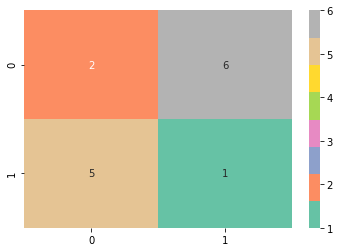

In [7]:
# organize imports
from __future__ import print_function

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import numpy as np
import h5py
import os
import json
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

# load the user configs
with open('conf/conf.json') as f:    
  config = json.load(f)

# config variables
test_size     = config["test_size"]
seed      = config["seed"]
features_path   = config["features_path"]
labels_path   = config["labels_path"]
results     = config["results"]
classifier_path = config["classifier_path"]
train_path    = config["train_path"]
num_classes   = config["num_classes"]
classifier_path = config["classifier_path"]

# import features and labels
h5f_data  = h5py.File(features_path, 'r')
h5f_label = h5py.File(labels_path, 'r')

features_string = h5f_data['dataset_1']
labels_string   = h5f_label['dataset_1']

features = np.array(features_string)
labels   = np.array(labels_string)

h5f_data.close()
h5f_label.close()

# verify the shape of features and labels
print ("[INFO] features shape: {}".format(features.shape))
print ("[INFO] labels shape: {}".format(labels.shape))

print ("[INFO] training started...")
# split the training and testing data
(trainData, testData, trainLabels, testLabels) = train_test_split(np.array(features),
                                                                  np.array(labels),
                                                                  test_size=test_size,
                                                                  random_state=seed)

print ("[INFO] splitted train and test data...")
print ("[INFO] train data  : {}".format(trainData.shape))
print ("[INFO] test data   : {}".format(testData.shape))
print ("[INFO] train labels: {}".format(trainLabels.shape))
print ("[INFO] test labels : {}".format(testLabels.shape))

# use logistic regression as the model
print ("[INFO] creating model...")
model = LogisticRegression(random_state=seed)
model.fit(trainData, trainLabels)

# evaluate the model of test data
preds = model.predict(testData)

# display the confusion matrix
print ("[INFO] confusion matrix")

# plot the confusion matrix
cm = confusion_matrix(testLabels, preds)
sns.heatmap(cm,
            annot=True,
            cmap="Set2")
plt.show()